# Training a classifier
Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a ```torch.*Tensor```.

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

## Training an Image Classifier

1. Load and normalizing the CIFAR10 training and test datasets using ```torchvision```
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

## 1. Loading and normalizing CIFAR10

In [1]:
# importing necessary packages
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# the o/p of torchvision datasets are PILImage images of range [0, 1]
# we transform them to tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5), (0.5, 0.5, 0.5))])

Run the code below once to download the CIFAR10 train and test dataset

In [3]:
# download and load the CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified


In [5]:
# classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog',' horse',
          'ship', 'truck')

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    '''
    Unnormalize and plot the image.
    '''
    img = img/2 + 0.5  # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [7]:
# get some random training images
data_iter = iter(trainloader)
images, labels = data_iter.next()

      bird        dog        dog      plane


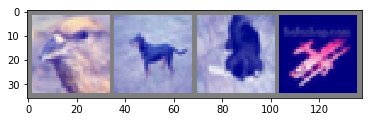

In [8]:
# show images 
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 150, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(150, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
net = Net()

## 3. Define a Loss function and optimizer

Using a Classification Cross-Entropy loss and SGD with momentum. (In this case)

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

In [48]:
epochs = 2

In [49]:
for epoch in range(epochs): # looping over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss +=loss.item()
        if i%2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 1.494
[1,  4000] loss: 1.439
[1,  6000] loss: 1.342
[1,  8000] loss: 1.321
[1, 10000] loss: 1.291
[1, 12000] loss: 1.229
[2,  2000] loss: 1.164
[2,  4000] loss: 1.157
[2,  6000] loss: 1.136
[2,  8000] loss: 1.126
[2, 10000] loss: 1.095
[2, 12000] loss: 1.082
Finished Training


## 5. Test the network on the test data

Ground Truth:
       cat       ship       ship      plane


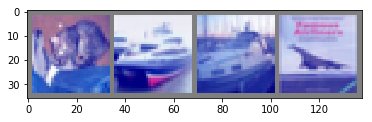

In [50]:
data_iter_test = iter(testloader)
images, labels = data_iter_test.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth:')
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [51]:
outputs = net(images)

In [52]:
# Testing on the above sample
_, predicted = torch.max(outputs, 1)
print('Predicted: ')
print(' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted: 
  cat plane plane plane


In [53]:
# Testing on the whole testset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total +=labels.size(0)
        correct += (predicted==labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct /total))

Accuracy of the network on the 10000 test images: 60 %


## Training on GPU
Just like how we transfer a Tensor on to the GPU, we can transfer the neural net onto the GPU.

In [54]:
# Check if GPU is available (CUDA device)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


These methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [55]:
net.to(device)

Net(
  (conv1): Conv2d(3, 150, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(150, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [56]:
# we have to send the i/p and targets at every step to the GPU too:
inputs, labels = inputs.to(device), labels.to(device)